### RFM 분석 실습
- Recency: 얼마나 최근에 구매했는가
- Frequency: 얼마나 자주 구매했는가
- Monetary: 얼마나 많은 금액을 지출했는가

### 고객 분석
- CustomerID: 고객 번호
- PurchaseDate: 구매 날짜
- TransactionAmount: 결제 금액
- ProductInformation: 상품 정보
- OrderID: 주문 번호
- Location: 주문 지역

In [1]:
import pandas as pd

# 데이터를 읽어옵니다.
path = "./datasets/customer_order_data.csv"
co_df = pd.read_csv(path)
display(co_df)

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris
...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London
996,6669,2023-06-10,941.50,Product C,987025,New York
997,8836,2023-06-10,545.36,Product C,512842,London
998,1440,2023-06-10,729.94,Product B,559753,Paris


In [2]:
# info()를 통해 데이터를 확인해봅니다.
co_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


#### 중복 행 검사

In [3]:
co_df.duplicated().sum()

0

#### 결측치 검사

In [4]:
co_df.isna().sum()

CustomerID            0
PurchaseDate          0
TransactionAmount     0
ProductInformation    0
OrderID               0
Location              0
dtype: int64

#### 이상치(Outlier) 검사

In [5]:
display(co_df[co_df['TransactionAmount'] < 0])

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location


#### 이상치가 없는 걸 확인한 후 다음으로 넘어갑니다.
- Q1, Q3, iqr을 통해 정상치 범위를 확인합니다.

In [6]:
import numpy as np

# TransactionAmount feature에 대한 정상치 범위 확인
Q1 = co_df.describe().T.loc['TransactionAmount', '25%']
Q3 = co_df.describe().T.loc['TransactionAmount', '75%']

iqr = Q3 - Q1

lower_bound = Q1 - 1.5 * iqr
upper_bound = Q3 + 1.5 * iqr

print(lower_bound, upper_bound)

-496.99 1513.97


#### lower_bound가 음수이므로 0으로 변경합니다.

In [7]:
lower_bound = 0

print(f'정상치 범위: {lower_bound} ~ {upper_bound}')

정상치 범위: 0 ~ 1513.97


In [8]:
co_df = co_df[co_df['TransactionAmount'] <= upper_bound]
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris
...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London
996,6669,2023-06-10,941.50,Product C,987025,New York
997,8836,2023-06-10,545.36,Product C,512842,London
998,1440,2023-06-10,729.94,Product B,559753,Paris


#### 인덱스와 row(행)의 개수가 일치하므로 정상치 범위에 포함되지 않는 TransactionAmount 값이 없었음을 알 수 있습니다.

### 데이터 전처리
- PurchaseDate를 CustomerID로 groupby한 후 가장 최근의 날짜를 현재 날짜에서 차감하여 Recency로 변환
- CustomerID별로 등장 횟수를 집계하여 Frequency로 변환
- TransactionAmount를 CustomerID로 groupby하여 총합을 Monetary에 저장

In [9]:
# PurchaseDate를 현재 날짜에서 차감하여 CustomerID로 groupby한 후 가장 최근의 날짜를 Recency로 변환
# PurchaseDate를 DateTime 타입으로 변환
co_df['PurchaseDate'] = pd.to_datetime(co_df['PurchaseDate'])
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris
...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London
996,6669,2023-06-10,941.50,Product C,987025,New York
997,8836,2023-06-10,545.36,Product C,512842,London
998,1440,2023-06-10,729.94,Product B,559753,Paris


In [10]:
# 현재 날짜 구하기
from datetime import datetime

current_date = datetime.now()
print(current_date)

2024-03-29 09:22:53.467646


In [11]:
# 현재 날짜와 PurchaseDate의 차이를 구하여 'Recency' 컬럼을 만들고 저장
co_df['Recency'] = (current_date - co_df['PurchaseDate']).dt.days
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,Recency
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,353
1,2188,2023-04-11,463.70,Product A,176819,London,353
2,4608,2023-04-11,80.28,Product A,340062,New York,353
3,2559,2023-04-11,221.29,Product A,239145,London,353
4,9482,2023-04-11,739.56,Product A,194545,Paris,353
...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,293
996,6669,2023-06-10,941.50,Product C,987025,New York,293
997,8836,2023-06-10,545.36,Product C,512842,London,293
998,1440,2023-06-10,729.94,Product B,559753,Paris,293


In [12]:
# CustomerID별로 groupby하여 가장 최근의 Recency로 변경
co_df['Recency'] = co_df.groupby('CustomerID')['Recency'].transform('min')
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,Recency
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,353
1,2188,2023-04-11,463.70,Product A,176819,London,353
2,4608,2023-04-11,80.28,Product A,340062,New York,353
3,2559,2023-04-11,221.29,Product A,239145,London,353
4,9482,2023-04-11,739.56,Product A,194545,Paris,353
...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,293
996,6669,2023-06-10,941.50,Product C,987025,New York,293
997,8836,2023-06-10,545.36,Product C,512842,London,293
998,1440,2023-06-10,729.94,Product B,559753,Paris,293


In [13]:
# CustomerID별로 등장 횟수를 집계하여 Frequency로 변환
co_df['Frequency'] = co_df.groupby('CustomerID')['CustomerID'].transform('count')
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,Recency,Frequency
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,353,1
1,2188,2023-04-11,463.70,Product A,176819,London,353,1
2,4608,2023-04-11,80.28,Product A,340062,New York,353,1
3,2559,2023-04-11,221.29,Product A,239145,London,353,1
4,9482,2023-04-11,739.56,Product A,194545,Paris,353,1
...,...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,293,1
996,6669,2023-06-10,941.50,Product C,987025,New York,293,1
997,8836,2023-06-10,545.36,Product C,512842,London,293,1
998,1440,2023-06-10,729.94,Product B,559753,Paris,293,1


In [14]:
# TransactionAmount를 CustomerID로 groupby하여 총합을 Monetary에 저장

co_df['Monetary'] = co_df.groupby('CustomerID')['TransactionAmount'].transform('sum')
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,Recency,Frequency,Monetary
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,353,1,943.31
1,2188,2023-04-11,463.70,Product A,176819,London,353,1,463.70
2,4608,2023-04-11,80.28,Product A,340062,New York,353,1,80.28
3,2559,2023-04-11,221.29,Product A,239145,London,353,1,221.29
4,9482,2023-04-11,739.56,Product A,194545,Paris,353,1,739.56
...,...,...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,293,1,759.62
996,6669,2023-06-10,941.50,Product C,987025,New York,293,1,941.50
997,8836,2023-06-10,545.36,Product C,512842,London,293,1,545.36
998,1440,2023-06-10,729.94,Product B,559753,Paris,293,1,729.94


In [15]:
# RFM으로 구성된 DataFrame 생성
co_rfm_df = co_df[['Recency', 'Frequency', 'Monetary']]
co_rfm_df

,Recency,Frequency,Monetary
0,353,1,943.31
1,353,1,463.70
2,353,1,80.28
3,353,1,221.29
4,353,1,739.56
...,...,...,...
995,293,1,759.62
996,293,1,941.50
997,293,1,545.36
998,293,1,729.94


#### 정규화(Normalization) 진행

In [16]:
from sklearn.preprocessing import MinMaxScaler

normalization = MinMaxScaler()
rfm_normalization = normalization.fit_transform(co_rfm_df)

In [17]:
co_rfm_df = pd.DataFrame(rfm_normalization, columns=co_rfm_df.columns)
co_rfm_df['Recency'] = 1 - co_rfm_df['Recency']
co_rfm_df

,Recency,Frequency,Monetary
0,0.0,0.0,0.393348
1,0.0,0.0,0.190752
2,0.0,0.0,0.028788
3,0.0,0.0,0.088353
4,0.0,0.0,0.307280
...,...,...,...
995,1.0,0.0,0.315754
996,1.0,0.0,0.392583
997,1.0,0.0,0.225246
998,1.0,0.0,0.303216


In [18]:
# co_df에 TotalScore 컬럼을 만들어 RFM 점수 담기
co_df['TotalScore'] = co_rfm_df['Recency'] + co_rfm_df['Frequency'] + co_rfm_df['Monetary']
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,Recency,Frequency,Monetary,TotalScore
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,353,1,943.31,0.393348
1,2188,2023-04-11,463.70,Product A,176819,London,353,1,463.70,0.190752
2,4608,2023-04-11,80.28,Product A,340062,New York,353,1,80.28,0.028788
3,2559,2023-04-11,221.29,Product A,239145,London,353,1,221.29,0.088353
4,9482,2023-04-11,739.56,Product A,194545,Paris,353,1,739.56,0.307280
...,...,...,...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,293,1,759.62,1.315754
996,6669,2023-06-10,941.50,Product C,987025,New York,293,1,941.50,1.392583
997,8836,2023-06-10,545.36,Product C,512842,London,293,1,545.36,1.225246
998,1440,2023-06-10,729.94,Product B,559753,Paris,293,1,729.94,1.303216


In [19]:
co_df.drop(columns=['Recency', 'Frequency', 'Monetary'], axis=1, inplace=True)
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,TotalScore
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,0.393348
1,2188,2023-04-11,463.70,Product A,176819,London,0.190752
2,4608,2023-04-11,80.28,Product A,340062,New York,0.028788
3,2559,2023-04-11,221.29,Product A,239145,London,0.088353
4,9482,2023-04-11,739.56,Product A,194545,Paris,0.307280
...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,1.315754
996,6669,2023-06-10,941.50,Product C,987025,New York,1.392583
997,8836,2023-06-10,545.36,Product C,512842,London,1.225246
998,1440,2023-06-10,729.94,Product B,559753,Paris,1.303216


In [20]:
# RFM score(TotalScore)를 기준으로 5개의 등급으로 나누기
import numpy as np

l1, l2, l3, l4 = np.percentile(co_df['TotalScore'], [20, 45, 70, 90])
print(l1, l2, l3, l4)

0.4310081160693664 0.7138154396814397 0.9937367149350315 1.3033258706047344


In [21]:
def get_level(x):
    if x <= l1:
        return 5
    if x <= l2:
        return 4
    if x <= l3:
        return 3
    if x <= l4:
        return 2
    return 1

In [22]:
# Level 컬럼을 만들어 RFM Score(TotalScore)에 맞는 등급을 숫자로 저장
co_df['Level'] = co_df['TotalScore'].apply(get_level)
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,TotalScore,Level
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,0.393348,5
1,2188,2023-04-11,463.70,Product A,176819,London,0.190752,5
2,4608,2023-04-11,80.28,Product A,340062,New York,0.028788,5
3,2559,2023-04-11,221.29,Product A,239145,London,0.088353,5
4,9482,2023-04-11,739.56,Product A,194545,Paris,0.307280,5
...,...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,1.315754,1
996,6669,2023-06-10,941.50,Product C,987025,New York,1.392583,1
997,8836,2023-06-10,545.36,Product C,512842,London,1.225246,2
998,1440,2023-06-10,729.94,Product B,559753,Paris,1.303216,2


In [23]:
# 숫자로 된 각 등급을 문자열(Bronze, Silver, Gold, Diamond, VIP)로 변경
classes = ['Bronze', 'Silver', 'Gold', 'Diamond', 'VIP']
co_df['Level'] = co_df['Level'].replace([5, 4, 3, 2, 1], classes)
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,TotalScore,Level
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,0.393348,Bronze
1,2188,2023-04-11,463.70,Product A,176819,London,0.190752,Bronze
2,4608,2023-04-11,80.28,Product A,340062,New York,0.028788,Bronze
3,2559,2023-04-11,221.29,Product A,239145,London,0.088353,Bronze
4,9482,2023-04-11,739.56,Product A,194545,Paris,0.307280,Bronze
...,...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,1.315754,VIP
996,6669,2023-06-10,941.50,Product C,987025,New York,1.392583,VIP
997,8836,2023-06-10,545.36,Product C,512842,London,1.225246,Diamond
998,1440,2023-06-10,729.94,Product B,559753,Paris,1.303216,Diamond


In [24]:
# 각 등급에 맞는 데이터 수 확인
print(co_df['Level'].value_counts())

Level
Silver     250
Gold       250
Bronze     200
Diamond    200
VIP        100
Name: count, dtype: int64


#### 데이터 시각화하기

<Axes: xlabel='Level', ylabel='count'>

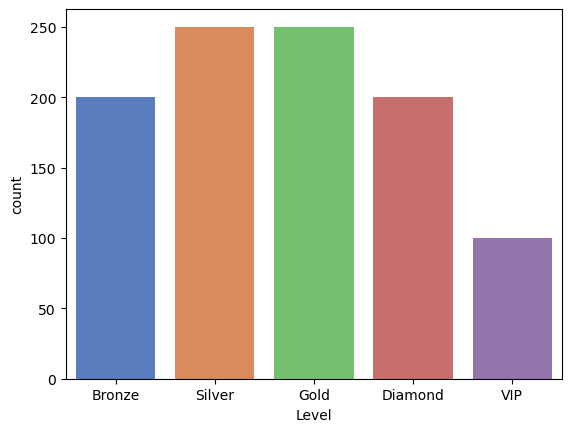

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 각 등급에 맞는 데이터 개수를 시각화합니다.
classes = ['Bronze', 'Silver', 'Gold', 'Diamond', 'VIP']
sns.countplot(x='Level', data=co_df, palette='muted', order=classes)

In [26]:
co_df

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,TotalScore,Level
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,0.393348,Bronze
1,2188,2023-04-11,463.70,Product A,176819,London,0.190752,Bronze
2,4608,2023-04-11,80.28,Product A,340062,New York,0.028788,Bronze
3,2559,2023-04-11,221.29,Product A,239145,London,0.088353,Bronze
4,9482,2023-04-11,739.56,Product A,194545,Paris,0.307280,Bronze
...,...,...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London,1.315754,VIP
996,6669,2023-06-10,941.50,Product C,987025,New York,1.392583,VIP
997,8836,2023-06-10,545.36,Product C,512842,London,1.225246,Diamond
998,1440,2023-06-10,729.94,Product B,559753,Paris,1.303216,Diamond


<Axes: xlabel='ProductInformation', ylabel='count'>

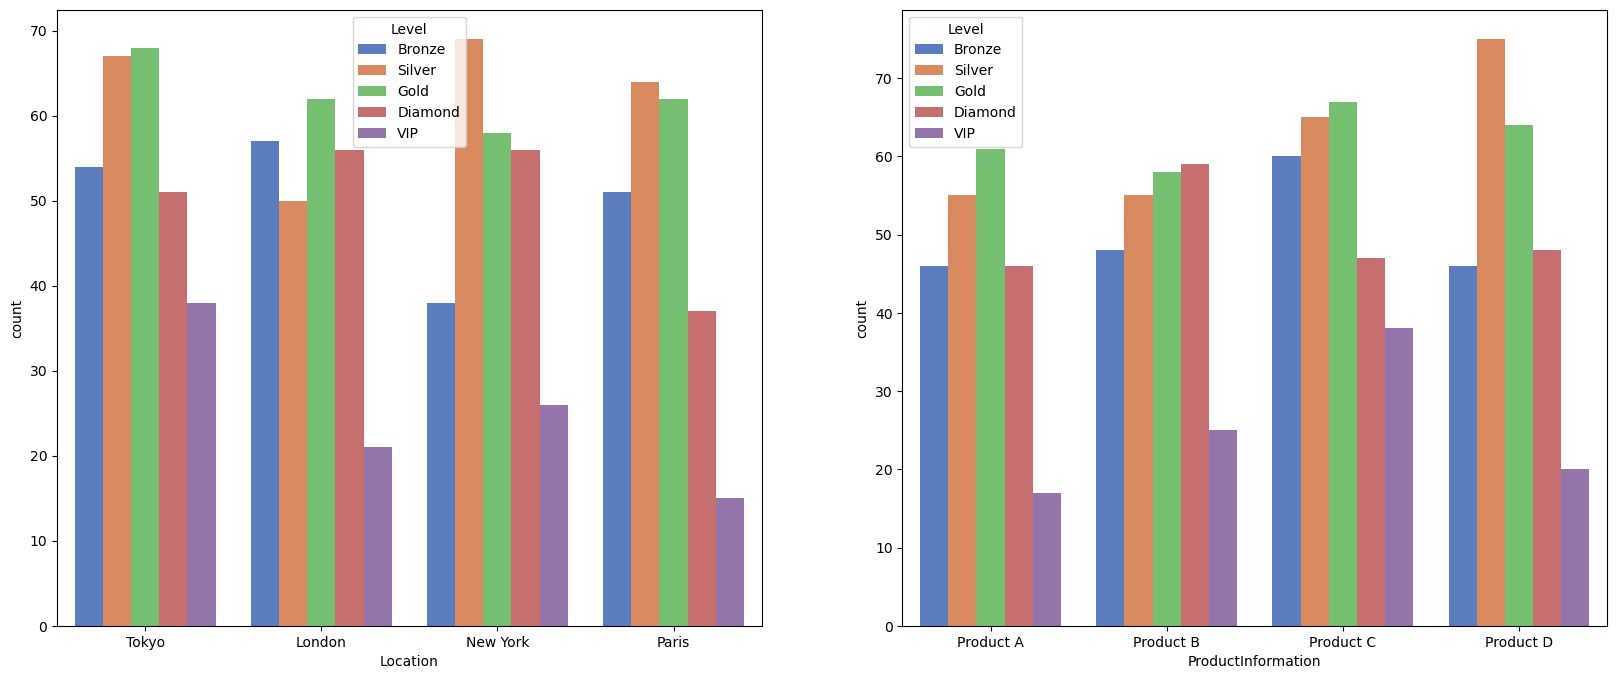

In [27]:
# 지역별, 제품(Product) 종류별 등급에 맞는 데이터 개수를 시각화합니다.
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

classes = ['Bronze', 'Silver', 'Gold', 'Diamond', 'VIP']
order_products = ['Product A', 'Product B', 'Product C', 'Product D']
sns.countplot(ax=axes[0], x='Location', hue='Level', data=co_df, palette='muted', hue_order=classes)
sns.countplot(ax=axes[1], x='ProductInformation', hue='Level', data=co_df, palette='muted', hue_order=classes, order=order_products)

#### 주문 데이터 분석

- PurchaseDate를 CustomerID로 groupby한 후 가장 최근의 날짜를 현재 날짜에서 차감하여 Recency로 변환하여 저장했다.  
- CustomerID별로 등장 횟수를 집계하여 Frequency로 변환하였으며,     TransactionAmount를 CustomerID로 groupby하여 총합을 Monetary에 저장했다.
- 이 때 Recency, Frequency, Monetary 값에 대해 sklearn 라이브러리의 MinMaxScaler를 활용하여 정규화를 진행한 후,  
  각 값을 더한 RFM Score 값을 TotalScore 컬럼에 저장했다.
- TotalScore를 바탕으로 'Bronze', 'Silver', 'Gold', 'Diamond', 'VIP' 등 5개의 등급(그룹)으로 고객 데이터를 분류할 수 있었다.

- 'Silver'와 'Gold' 그룹에 속한 고객의 주문 데이터 수는 250개로 가장 많았으며, 'Bronze'와 'Diamond' 그룹에 속한 데이터가 200개로 다음 순위를 차지했다.  
  'VIP' 그룹의 경우 100개의 주문 데이터가 포함되어 가장 적은 수치를 보였다.

- 지역별로 각 그룹에 속하는 데이터를 시각화한 결과 도쿄와 런던의 고객들은 'Gold' 그룹의 비율이 가장 높게 나타났으며,   
  런던에서는 'Bronze' 그룹의 비율이 'Silver' 그룹의 비율보다 높게 나타났지만 도쿄에서는 반대로 'Silver' 그룹의 비율이 더 높게 나타났다.  
  한편 뉴욕과 파리의 고객들은 'Silver' 그룹에 속한 비율이 가장 높게 나타났다.  
  이는 RFM 점수를 기준으로 보았을 때 도쿄와 런던에 비해 뉴욕과 파리의 고객들이 상대적으로 덜 활동적인 경향을 보인다는 점을 시사한다.

- 상품별로 각 그룹에 속하는 데이터를 시각화한 결과 A 제품과 C 제품은 'Gold' 그룹의 고객들이, D 제품은 'Silver' 그룹의 고객들이,  
  그리고 B 제품은 'Diamond' 그룹의 고객들이 가장 많이 구매하였음을 확인할 수 있다.  
  각 제품마다 구매한 고객의 그룹이 다양하다는 점은 해당 제품들이 다양한 수요층을 가지고 있음을 시사한다.  
  특히 C 제품의 경우 다른 제품에 비해 'VIP' 그룹의 수요가 가장 많았다.  
  'Diamond' 그룹에 속하는 고객의 데이터 수가 'Silver'나 'Gold' 그룹의 데이터 수보다 적다는 사실을 고려할 때,  
  C 제품의 경우 더 활동적인 고객일 수록 수요가 증가하는 제품으로 볼 수 있다.

#### 마케팅 전략 제안
> 'VIP' 등급 고객의 주문 횟수가 상대적으로 낮은 파리의 경우 고객들을 대상으로 보다 높은 가치의 새로운 제품을 출시하거나 기존 제품 및 브랜드의 가치에 대한 인식을 제고하기 위한 캠페인을 진행하는 것이 효과적일 수 있습니다. 또한 'Bronze' 등급 고객의 주문 횟수가 비교적 높지 않은 뉴욕, 파리의 고객들을 대상으로 맞춤형 프로모션 및 할인을 제공하거나 이전 구매 제품에 대한 리뷰 및 평가를 유도함으로써, 제품 재구매율을 높이고 브랜드에 대한 신뢰와 만족도를 높일 수 있습니다.  
> 다른 제품에 비해 'VIP' 등급 고객의 주문 비율이 낮은 A 제품이나 D 제품의 경우 라인업에 새로운 제품을 추가하거나, 기존 제품을 업그레이드하여 'VIP' 등급 고객들에게 특별한 혜택을 제공함으로써 관심과 주문을 유도할 수 있습니다. 또한 'VIP' 등급 고객들의 긍정적인 리뷰를 유도하여 제품에 대한 신뢰를 높이고 제품의 가치를 강조하는 것이 효과적일 수 있습니다.